In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
from scipy.stats import gaussian_kde
import os
import yaml
import h5py
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import time

import warnings

In [2]:
import sys
sys.path.append(r'../tools_F-J/')
sys.path.append(r'../tools_F-J/toollib_DisbaCode')
from objective_function import (ObjectiveFunctionDerivativeUsed, Forward)
from toollib_DisbaCode import forward
from toollib_DisbaCode import objective_function
from toollib_DisbaCode import empirical_relation
from toollib_DisbaCode import plot_disp
from toollib_DisbaCode import plot_model
from toollib_DisbaCode import plot_lcurve
from toollib_DisbaCode import plot_inversion_paper   
from toollib_DisbaCode import plot_kernel

#from toollib_standard import maplib
#from toollib_standard import mathlib
#from toollib_standard import filelib
#from toollib_standard import stacklib
from toollib_standard import plotlib

In [3]:
flag_project = 1 # 0--regular; 1--repartrition; 2--voronoi
flag_mode = 2 # 0--fundamental; 1--Overtones; 2--Both
flag_forward = 1 # 0--no forward calculation; 1--forward calculation
file_init = 'initial/initial_model_4.txt'

In [4]:
if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

#name_project = 'project/output_FJSJ_16-01/'               
#name_project = 'project_repartrition/repartrition_01-03/'               
#name_project = 'project_voronoi/voronoi_01-03/'         

In [5]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.5_02--10-16Hz/


In [6]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [7]:
dir_ds = dir_project + info_basic['rdir_ds']
dir_partition = dir_project + info_basic['rdir_partition']
dir_inv = dir_project + info_basic['rdir_inv_BFGS']
f0 = info_basic_bi['f']
c = np.linspace(info_basic['fj_c_min'], info_basic['fj_c_max'], info_basic['fj_c_num'])

In [8]:
file_config_fund = 'config_inv_fund.yml'
file_config = 'config_inv.yml'

In [9]:
dir_image = dir_project + info_basic['rdir_image'] + 'paper_tomo/'
if not os.path.exists(dir_image):
    os.mkdir(dir_image)

if flag_mode != 0:
    info_basic['rdir_BFGS_invfile'] = info_basic['rdir_inv_BFGS'] + 'inversion/'
    info_basic['rdir_disp_model'] = info_basic['rdir_inv_BFGS'] + 'disp_model/'
    info_basic['rdir_model'] = info_basic['rdir_inv_BFGS'] + 'model/'
    dir_invfile = dir_project + info_basic['rdir_BFGS_invfile']
    dir_disp_model = dir_project + info_basic['rdir_disp_model']
    dir_model = dir_project + info_basic['rdir_model']

    if not os.path.exists(dir_invfile):
        os.mkdir(dir_invfile)
    if not os.path.exists(dir_disp_model):
        os.mkdir(dir_disp_model)
    if not os.path.exists(dir_model):
        os.mkdir(dir_model)
if flag_mode !=  1:
    info_basic['rdir_BFGS_invfile_fund'] = info_basic['rdir_inv_BFGS'] + 'inversion_fund/'
    info_basic['rdir_disp_model_fund'] = info_basic['rdir_inv_BFGS'] + 'disp_model_fund/'
    info_basic['rdir_model_fund'] = info_basic['rdir_inv_BFGS'] + 'model_fund/'
    dir_invfile_fund = dir_project + info_basic['rdir_BFGS_invfile_fund']
    dir_disp_model_fund = dir_project + info_basic['rdir_disp_model_fund']
    dir_model_fund = dir_project + info_basic['rdir_model_fund']
    if not os.path.exists(dir_invfile_fund):
        os.mkdir(dir_invfile_fund)
    if not os.path.exists(dir_disp_model_fund):
        os.mkdir(dir_disp_model_fund)
    if not os.path.exists(dir_model_fund):
        os.mkdir(dir_model_fund)

In [10]:
with open(dir_inv+file_config, 'r') as fp:
    config = yaml.safe_load(fp)
with open(dir_inv+file_config_fund, 'r') as fp:
    config_fund = yaml.safe_load(fp)

c_map = 'jet'
v_max = None
v_min = 0.1

all_disp = 0
show_std = 1
show_init = 0
plot_fund = 1
xlim_f = [0.5,30]
xlim_T = [-1,1]
ylim_c = [0.25,1.8]
clim = [0,1]
fmin = 1
fmax = 30
cmin = 0.1
cmax = 2.5
vmax = 0.3

max_mode = 4

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


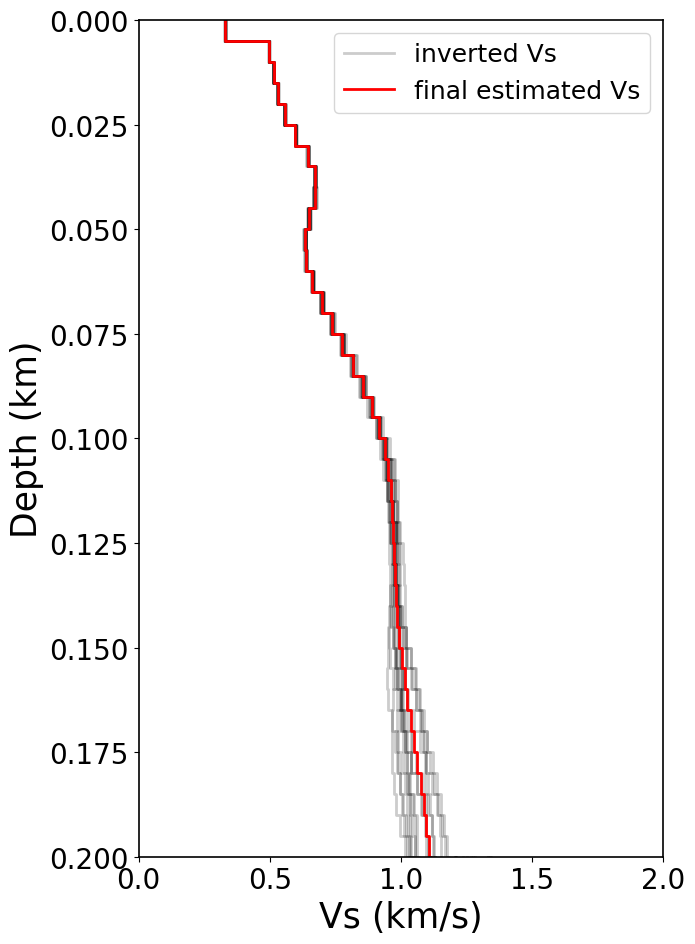

In [19]:
key_subwork = '244--35-09'
plt.style.use('tomo_paper.mplstyle')
file_inv =  'ds_'+key_subwork+'curve'
file_disp_data = dir_project + info_basic['rdir_disp_pick']+'ds_'+key_subwork+'curve.txt'
if flag_mode != 0:
    file_model = 'model_'+key_subwork+'.txt'
    file_disp_forward = dir_disp_model +  'disp_model_'+key_subwork+'.txt'
    if not os.path.exists(dir_invfile+file_inv):
        print(key_subwork+'Overtone inversion data file not exist')
        plt.close()
if flag_mode != 1: 
    file_model_fund = 'model_'+key_subwork+'.txt'
    file_disp_forward_fund = dir_disp_model_fund +  'disp_model_'+key_subwork+'.txt'
    if not os.path.exists(dir_invfile_fund+file_inv):
        print(key_subwork+' Fundamental inversion data file not exist')
        plt.close()
fig = plt.figure(figsize = (7.5, 10))
ax_inv = fig.add_subplot(111)
ax_inv,handles,labels = plot_inversion_paper.plot_model(config, file_inv, show_init, file_model,file_init,ax_inv,dir_this = dir_inv)
model = np.loadtxt(dir_model + file_model)
z = model[:, 1]
z = np.append(z, z[-1]*1.2)
vs = model[:, 3]
vs = np.append(vs, vs[-1])
p3,= ax_inv.step(vs, z, 'r-', lw=2)
handles.append(p3)
labels.append('final estimated Vs')
ax_inv.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.savefig(dir_image+'fjworkflow_inversion.eps')